min_broke_age= 39 mean_broke_age= 88.92 std_broke_age= 21.255907414175475 broke_age_failure= 36.0


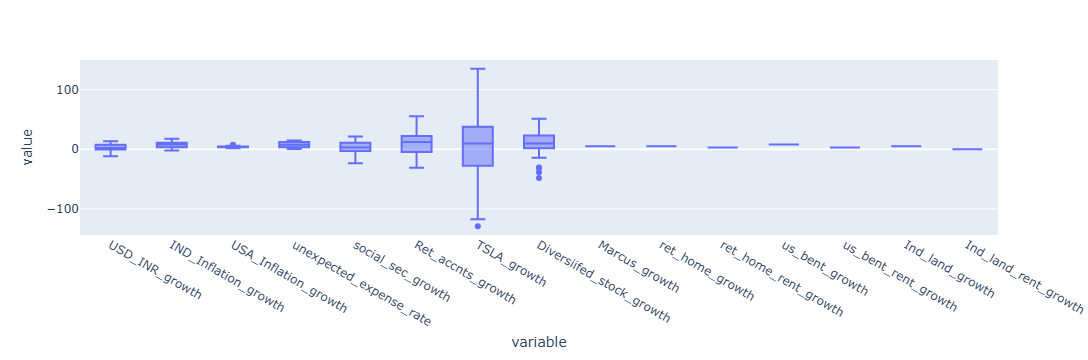

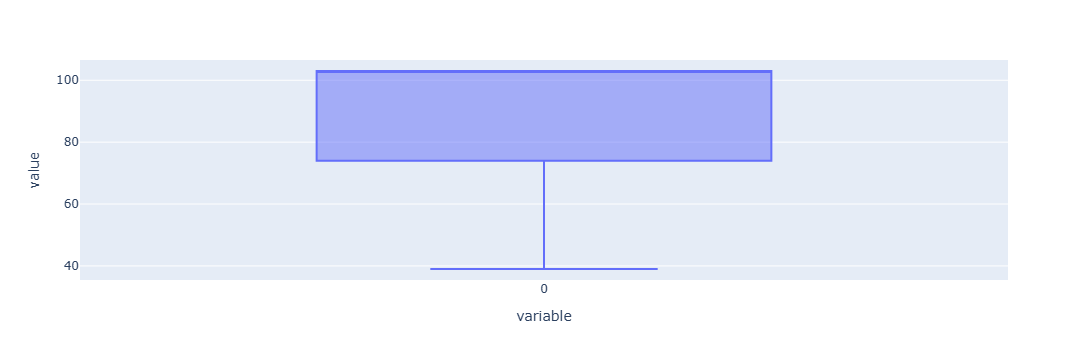

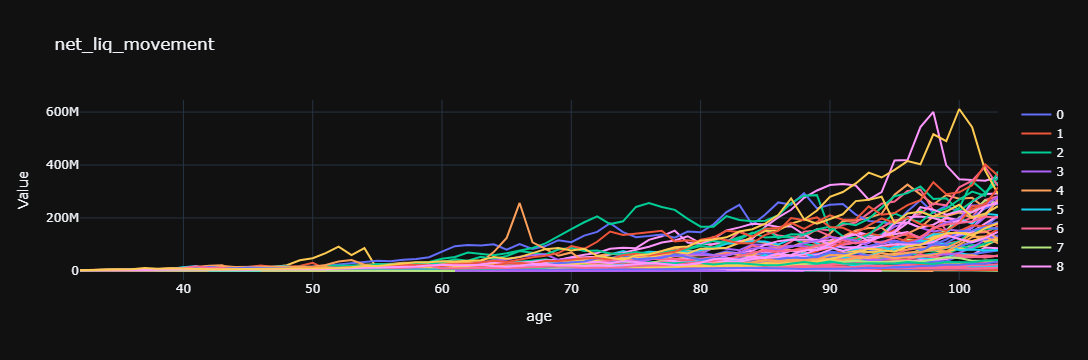

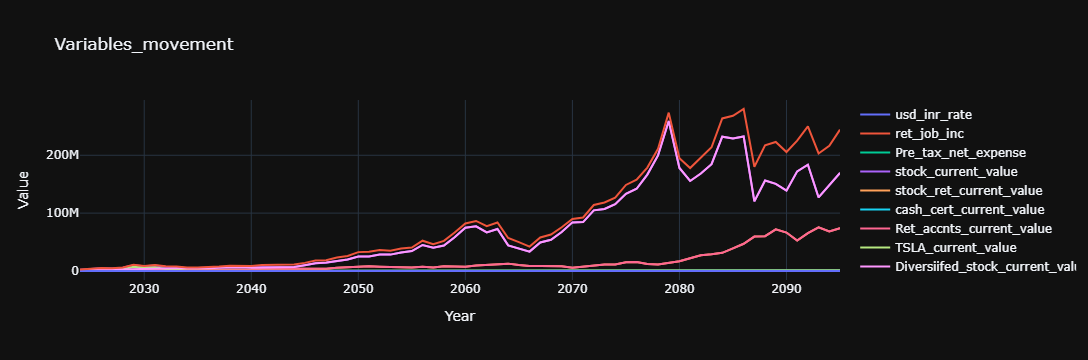

In [5]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px
import requests
from datetime import datetime

# -------------------------
# Configuration Parameters
# -------------------------

# Age and Retirement Variables
year_of_birth = 1992
Age_diff_spouse = 4
retirement_year = 2028

# Market parameters
stock_market_mean_yoy_growthrate_percent = 8
stock_market_std_yoy_growthrate = 18.0977

# Investment details
Investments = {
    'Ret_accnts': {
        'type': 'stock_retirement',
        'current_value': 214889,
        'beta': 1,
        'mean_yoy_growthrate_percent': 10.26,
        'std_yoy_growthrate': 18.0977,
        'additions_yearly': 0,
        'currency': 'USD'
    },
    'TSLA': {
        'type': 'stock',
        'current_value': 813324,
        'beta': 1,
        'mean_yoy_growthrate_percent': 9,
        'std_yoy_growthrate': 58.0977,
        'additions_yearly': 0,
        'currency': 'USD'
    },
    'Diversiifed_stock': {
        'type': 'stock',
        'current_value': 537598,
        'beta': 1,
        'mean_yoy_growthrate_percent': 10.26,
        'std_yoy_growthrate': 18.0977,
        'additions_yearly': 0,
        'currency': 'USD'
    },
    'Marcus': {
        'type': 'cash_certificate',
        'current_value': 20000,
        'additions_yearly': 0,
        'mean_yoy_growthrate_percent': 5,
        'currency': 'USD'
    },
    'ret_home': {
        'type': 'real_estate',
        'current_value': 24900000,
        'mean_yoy_growthrate_percent': 5,
        'down_percent': 20,
        'mortgage_term': 30,  # Years
        'mortgage_start_year': retirement_year,
        'mortgage_percent': 9.85,
        'closing_costs_onetime': 3500000,
        'currency': 'INR',
        'rental_income': 0,
        'rental_income_yoy_inc_percent': 3,
        'property_tax_percent': 1.36,
        'HOA_or_maintainance': 2000,
        'home_insurance': 13900,
        'yearly_misc_repair_or_other': 120000
    },
    'us_bent': {
        'type': 'real_estate',
        'current_value': 300000,
        'mean_yoy_growthrate_percent': 7.83,
        'down_percent': 20,
        'mortgage_term': 30,  # Years
        'mortgage_start_year': 2025,
        'mortgage_percent': 6.25,
        'closing_costs_onetime': 30000,
        'currency': 'USD',
        'rental_income': 1500,
        'rental_income_yoy_inc_percent': 3,
        'property_tax_percent': 1.36,
        'HOA_or_maintainance': 200,
        'home_insurance': 50,
        'yearly_misc_repair_or_other': 1200
    },
    'Ind_land': {
        'type': 'real_estate',
        'current_value': 5000000,
        'mean_yoy_growthrate_percent': 5,
        'down_percent': 50,
        'mortgage_term': 15,  # Years
        'mortgage_start_year': 2025,
        'mortgage_percent': 6.25,
        'closing_costs_onetime': 500000,
        'currency': 'INR',
        'rental_income': 0,
        'rental_income_yoy_inc_percent': 0,
        'property_tax_percent': 1.36,
        'HOA_or_maintainance': 10000,
        'home_insurance': 0,
        'yearly_misc_repair_or_other': 0
    }
}

# Social Security
social_sec = {
    'type': 'social_security',
    'withdrawl_age': 62,
    'inflated_income_per_month': 2300,
    'avg_cola_yoy_growth': 2.6,
    'avg_cola_std': 10
}

# Inflation and Currency Variables
USA_inflation_mean = 4
USA_inflation_std = 1
Monthly_living = 200000
Monthly_living_currency = 'INR'  # USD or INR
India_inflation_mean = 7.379
India_inflation_std = 4.878
Unexpected_expense_min_percent = 0.5
Unexpected_expense_max_percent = 15

# Post-Retirement Job
job_income_after_ret_annum = 2000000
job_yoy_increment_percent = 3
job_years_after_ret = 4
job_parameter_curency = 'INR'  # USD or INR

# Tax Brackets (Not fully used, but kept for reference)
US_federal_brackets = [
    (0, 22000, 0.10),
    (22000, 89450, 0.12),
    (89450, 190750, 0.22),
    (190750, 364200, 0.24),
    (364200, 462500, 0.32),
    (462500, 693750, 0.35),
    (693750, 1_000_000, 0.37)
]

US_state_brackets = [
    (0, 20198, 0.01),
    (20198, 47884, 0.02),
    (47884, 75576, 0.04),
    (75576, 104910, 0.06),
    (104910, 132590, 0.08),
    (132590, 677278, 0.093),
    (677278, 812728, 0.103),
    (812728, 1354550, 0.113),
    (1354550, 1_000_000, 0.123)
]

effective_tax_usa = 32
effective_tax_ind = 30

India_federal_brackets = [
    (0, 250000, 0.0),
    (250000, 500000, 0.05),
    (500000, 1000000, 0.20),
    (1000000, 10000000, 0.30)
]

default_USD_to_INR = 83.5
USD_INR_comission_percent = 0.550
USD_INR_mean_growth_percent = 3.040
USD_INR_STD = 5.57

# Fetch live USD to INR rate
try:
    response = requests.get("https://api.exchangerate-api.com/v4/latest/USD")
    data = response.json()
    USD_INR_rate = data["rates"]["INR"]
except:
    USD_INR_rate = default_USD_to_INR
    print('unable to reach server to get live USD to INR, using default USD to INR')

# Calculations for simulation span
current_year = datetime.now().year
target_survival_year = year_of_birth + Age_diff_spouse + 100
years_to_calculate = target_survival_year - current_year

# -------------------------
# Helper Functions
# -------------------------

def calculate_mortgage_payment(principal, annual_rate, term_years):
    """
    Calculate monthly mortgage payment using the standard mortgage formula.
    """
    monthly_rate = annual_rate / 12 / 100
    payments = term_years * 12
    return principal * monthly_rate / (1 - (1 + monthly_rate) ** -payments)


def adjust_rand(generated_values, target_mean, target_std):
    """
    Adjust a random sample to have a specific mean and standard deviation.
    """
    current_mean = np.mean(generated_values)
    current_std = np.std(generated_values)

    if current_std == 0:
        adjusted_values = np.full_like(generated_values, target_mean)
    else:
        adjusted_values = (generated_values - current_mean) / current_std * target_std + target_mean
    return adjusted_values


def gen_simulation_variables():
    """
    Generate random variables for simulation:
    - USD to INR growth
    - India inflation
    - USA inflation
    - Unexpected expenses
    - Social Security growth
    - Investment YOY growth (including rents)
    """
    rand_var_df = pd.DataFrame()
    rand_var_df['USD_INR_growth'] = adjust_rand(
        np.random.normal(loc=USD_INR_mean_growth_percent, scale=USD_INR_STD, size=years_to_calculate),
        USD_INR_mean_growth_percent, USD_INR_STD
    )
    rand_var_df['IND_Inflation_growth'] = adjust_rand(
        np.random.normal(loc=India_inflation_mean, scale=India_inflation_std, size=years_to_calculate),
        India_inflation_mean, India_inflation_std
    )
    rand_var_df['USA_Inflation_growth'] = adjust_rand(
        np.random.normal(loc=USA_inflation_mean, scale=USA_inflation_std, size=years_to_calculate),
        USA_inflation_mean, USA_inflation_std
    )
    rand_var_df['unexpected_expense_rate'] = np.random.uniform(
        Unexpected_expense_min_percent, Unexpected_expense_max_percent, size=years_to_calculate
    )
    rand_var_df['social_sec_growth'] = adjust_rand(
        np.random.normal(loc=social_sec['avg_cola_yoy_growth'], scale=social_sec['avg_cola_std'], size=years_to_calculate),
        social_sec['avg_cola_yoy_growth'], social_sec['avg_cola_std']
    )

    for key, invs in Investments.items():
        means = invs.get('mean_yoy_growthrate_percent', 5)
        std_dev = invs.get('std_yoy_growthrate', 0)

        rand_var_df[f'{key}_growth'] = adjust_rand(
            np.random.normal(loc=means, scale=std_dev, size=years_to_calculate),
            means, std_dev
        )

        if invs['type'] == 'real_estate':
            rand_var_df[f'{key}_rent_growth'] = adjust_rand(
                np.random.normal(loc=invs['rental_income_yoy_inc_percent'], scale=0, size=years_to_calculate),
                invs['rental_income_yoy_inc_percent'], 0
            )

    return rand_var_df


def simulate_retirement(simulation_var_df):
    """
    Perform yearly retirement simulation:
    - Adjust for inflation, unexpected expenses, mortgage costs.
    - Withdraw from investments if needed.
    - Track if/when the money runs out.
    """
    simulation_var_df['year'] = current_year + simulation_var_df.index
    simulation_var_df['age'] = current_year + simulation_var_df.index - year_of_birth

    for sim_year in simulation_var_df.index:
        # USD to INR rate calculation
        if sim_year == 0:
            simulation_var_df.loc[sim_year, 'usd_inr_rate'] = USD_INR_rate
        else:
            simulation_var_df.loc[sim_year, 'usd_inr_rate'] = simulation_var_df.loc[sim_year - 1, 'usd_inr_rate'] * (
                1 + simulation_var_df.loc[sim_year, 'USD_INR_growth'] / 100
            )

        # Inflation adjustments for living expenses
        if sim_year == 0:
            simulation_var_df.loc[sim_year, 'inflated_living'] = Monthly_living
        else:
            simulation_var_df.loc[sim_year, 'inflated_living'] = (
                simulation_var_df.loc[sim_year - 1, 'inflated_living'] *
                (1 + simulation_var_df.loc[sim_year - 1, 'IND_Inflation_growth'] / 100)
            )

        # Living and unexpected expenses post-retirement
        if simulation_var_df.loc[sim_year, 'year'] < retirement_year:
            simulation_var_df.loc[sim_year, 'living_expense'] = 0
            simulation_var_df.loc[sim_year, 'unexpected_expense'] = 0
        else:
            simulation_var_df.loc[sim_year, 'living_expense'] = simulation_var_df.loc[sim_year, 'inflated_living'] * 12
            simulation_var_df.loc[sim_year, 'unexpected_expense'] = (
                simulation_var_df.loc[sim_year, 'living_expense'] *
                (simulation_var_df.loc[sim_year, 'unexpected_expense_rate'] / 100)
            )

        # Post-retirement job income
        if (simulation_var_df.loc[sim_year, 'year'] < retirement_year) or \
           (simulation_var_df.loc[sim_year, 'year'] > retirement_year + job_years_after_ret):
            simulation_var_df.loc[sim_year, 'ret_job_inc'] = 0
        elif simulation_var_df.loc[sim_year, 'year'] == retirement_year:
            simulation_var_df.loc[sim_year, 'ret_job_inc'] = job_income_after_ret_annum
        else:
            simulation_var_df.loc[sim_year, 'ret_job_inc'] = simulation_var_df.loc[sim_year - 1, 'ret_job_inc'] * (
                1 + job_yoy_increment_percent / 100
            )

        # Net living (INR) to USD
        simulation_var_df.loc[sim_year, 'post_tax_living_USD_needed'] = (
            (simulation_var_df.loc[sim_year, 'living_expense'] +
             simulation_var_df.loc[sim_year, 'unexpected_expense'] -
             simulation_var_df.loc[sim_year, 'ret_job_inc']) /
            simulation_var_df.loc[sim_year, 'usd_inr_rate']
        )

        # Initialize yearly mortgage totals
        simulation_var_df.loc[sim_year, 'post_tax_all_mortgage'] = 0

        # Calculate mortgages and real estate costs
        for key, invs in Investments.items():
            if invs['type'] == 'real_estate':
                # Base mortgage payment
                if (simulation_var_df.loc[sim_year, 'year'] < invs['mortgage_start_year']) or \
                   (simulation_var_df.loc[sim_year, 'year'] > invs['mortgage_start_year'] + invs['mortgage_term']):
                    simulation_var_df.loc[sim_year, f'{key}_base_mortgage'] = 0
                else:
                    simulation_var_df.loc[sim_year, f'{key}_base_mortgage'] = (
                        calculate_mortgage_payment(
                            invs['current_value'] * (1 - invs['down_percent'] / 100),
                            invs['mortgage_percent'],
                            invs['mortgage_term']
                        ) * 12
                    )

                # Inflated yearly maintenance or repairs
                if simulation_var_df.loc[sim_year, 'year'] <= invs['mortgage_start_year']:
                    simulation_var_df.loc[sim_year, f'{key}_inflated'] = (
                        invs['yearly_misc_repair_or_other'] + invs['HOA_or_maintainance']
                    )
                else:
                    if invs['currency'] == 'USD':
                        simulation_var_df.loc[sim_year, f'{key}_inflated'] = \
                            simulation_var_df.loc[sim_year - 1, f'{key}_inflated'] * \
                            (1 + simulation_var_df.loc[sim_year, 'USA_Inflation_growth'] / 100)
                    else:
                        simulation_var_df.loc[sim_year, f'{key}_inflated'] = \
                            simulation_var_df.loc[sim_year - 1, f'{key}_inflated'] * \
                            (1 + simulation_var_df.loc[sim_year, 'IND_Inflation_growth'] / 100)

                # Rental income inflation
                if simulation_var_df.loc[sim_year, 'year'] <= invs['mortgage_start_year']:
                    simulation_var_df.loc[sim_year, f'{key}_rent_inflated'] = invs['rental_income']
                else:
                    simulation_var_df.loc[sim_year, f'{key}_rent_inflated'] = (
                        simulation_var_df.loc[sim_year - 1, f'{key}_rent_inflated'] *
                        (1 + simulation_var_df.loc[sim_year, f'{key}_rent_growth'] / 100)
                    )

                # Mortgage and property costs
                if simulation_var_df.loc[sim_year, 'year'] < invs['mortgage_start_year']:
                    simulation_var_df.loc[sim_year, f'{key}_mortgage'] = 0
                    simulation_var_df.loc[sim_year, f'{key}_one_time_mortgage'] = 0
                else:
                    if simulation_var_df.loc[sim_year, 'year'] == invs['mortgage_start_year']:
                        simulation_var_df.loc[sim_year, f'{key}_one_time_mortgage'] = (
                            (invs['down_percent'] * invs['current_value'] / 100) + invs['closing_costs_onetime']
                        )
                    else:
                        simulation_var_df.loc[sim_year, f'{key}_one_time_mortgage'] = 0

                    simulation_var_df.loc[sim_year, f'{key}_mortgage'] = (
                        simulation_var_df.loc[sim_year, f'{key}_base_mortgage'] +
                        invs['current_value'] * (invs['property_tax_percent'] / 100) +
                        invs['home_insurance'] +
                        simulation_var_df.loc[sim_year, f'{key}_inflated'] -
                        simulation_var_df.loc[sim_year, f'{key}_rent_inflated'] +
                        simulation_var_df.loc[sim_year, f'{key}_one_time_mortgage']
                    )

                    # Convert mortgage expenses to USD if property is INR-based
                    if invs['currency'] == 'INR':
                        simulation_var_df.loc[sim_year, f'{key}_mortgage'] = (
                            simulation_var_df.loc[sim_year, f'{key}_mortgage'] /
                            simulation_var_df.loc[sim_year, 'usd_inr_rate']
                        )

                simulation_var_df.loc[sim_year, 'post_tax_all_mortgage'] += simulation_var_df.loc[sim_year, f'{key}_mortgage']

        simulation_var_df.loc[sim_year, 'post_tax_net_expense'] = (
            simulation_var_df.loc[sim_year, 'post_tax_all_mortgage'] +
            simulation_var_df.loc[sim_year, 'post_tax_living_USD_needed']
        )

        # Pre-tax expense calculation
        # For 2 years after retirement, use USA tax; afterward, use India tax
        if simulation_var_df.loc[sim_year, 'year'] <= retirement_year + 2:
            if effective_tax_usa != 0:
                simulation_var_df.loc[sim_year, 'Pre_tax_net_expense'] = (
                    simulation_var_df.loc[sim_year, 'post_tax_net_expense'] / (1 - effective_tax_usa / 100)
                )
            else:
                simulation_var_df.loc[sim_year, 'Pre_tax_net_expense'] = simulation_var_df.loc[sim_year, 'post_tax_net_expense']
        else:
            if effective_tax_ind != 0:
                simulation_var_df.loc[sim_year, 'Pre_tax_net_expense'] = (
                    simulation_var_df.loc[sim_year, 'post_tax_net_expense'] / (1 - effective_tax_ind / 100)
                )
            else:
                simulation_var_df.loc[sim_year, 'Pre_tax_net_expense'] = simulation_var_df.loc[sim_year, 'post_tax_net_expense']

        # Investment growth and withdrawal
        simulation_var_df.loc[sim_year, 'stock_current_value'] = 0
        simulation_var_df.loc[sim_year, 'stock_ret_current_value'] = 0
        simulation_var_df.loc[sim_year, 'cash_cert_current_value'] = 0

        # Update investment values based on growth
        for key, invsts in Investments.items():
            if invsts['type'] in ['stock', 'stock_retirement', 'cash_certificate']:
                if sim_year == 0:
                    simulation_var_df.loc[sim_year, f'{key}_current_value'] = invsts['current_value']
                else:
                    simulation_var_df.loc[sim_year, f'{key}_current_value'] = (
                        simulation_var_df.loc[sim_year - 1, f'{key}_current_value'] *
                        (1 + (simulation_var_df.loc[sim_year - 1, f'{key}_growth'] / 100))
                    )

                # Aggregate current values by type
                if invsts['type'] == 'stock':
                    simulation_var_df.loc[sim_year, 'stock_current_value'] += simulation_var_df.loc[sim_year, f'{key}_current_value']
                elif invsts['type'] == 'stock_retirement':
                    simulation_var_df.loc[sim_year, 'stock_ret_current_value'] += simulation_var_df.loc[sim_year, f'{key}_current_value']
                elif invsts['type'] == 'cash_certificate':
                    simulation_var_df.loc[sim_year, 'cash_cert_current_value'] += simulation_var_df.loc[sim_year, f'{key}_current_value']

        # Calculate withdrawals
        simulation_var_df.loc[sim_year, 'Pre_tax_expense_left'] = simulation_var_df.loc[sim_year, 'Pre_tax_net_expense'] * 1

        # Social Security income reduction
        if simulation_var_df.loc[sim_year, 'year'] >= (social_sec['withdrawl_age'] + year_of_birth):
            simulation_var_df.loc[sim_year, 'Pre_tax_expense_left'] -= social_sec['inflated_income_per_month'] * 12

        inv_rat = {}

        # Withdraw from stocks
        if (simulation_var_df.loc[sim_year, 'Pre_tax_expense_left'] > 0) and (simulation_var_df.loc[sim_year, 'stock_current_value'] > 0):
            for key, invsts in Investments.items():
                if invsts['type'] == 'stock':
                    inv_rat[f'{key}'] = (simulation_var_df.loc[sim_year, f'{key}_current_value'] /
                                         simulation_var_df.loc[sim_year, 'stock_current_value'])

            if simulation_var_df.loc[sim_year, 'Pre_tax_expense_left'] <= simulation_var_df.loc[sim_year, 'stock_current_value']:
                simulation_var_df.loc[sim_year, 'stock_current_value'] -= simulation_var_df.loc[sim_year, 'Pre_tax_expense_left']
                simulation_var_df.loc[sim_year, 'Pre_tax_expense_left'] = 0
            else:
                simulation_var_df.loc[sim_year, 'Pre_tax_expense_left'] -= simulation_var_df.loc[sim_year, 'stock_current_value']
                simulation_var_df.loc[sim_year, 'stock_current_value'] = 0

            for key, invsts in Investments.items():
                if invsts['type'] == 'stock':
                    simulation_var_df.loc[sim_year, f'{key}_current_value'] = (
                        inv_rat[f'{key}'] * simulation_var_df.loc[sim_year, 'stock_current_value']
                    )

        # Withdraw from retirement stock (penalty if age < 58)
        if (simulation_var_df.loc[sim_year, 'Pre_tax_expense_left'] > 0) and (simulation_var_df.loc[sim_year, 'stock_ret_current_value'] > 0):
            penalty_withdraw_multiplier = 1.1 if simulation_var_df.loc[sim_year, 'age'] < 58 else 1.0

            for key, invsts in Investments.items():
                if invsts['type'] == 'stock_retirement':
                    inv_rat[f'{key}'] = (
                        simulation_var_df.loc[sim_year, f'{key}_current_value'] /
                        simulation_var_df.loc[sim_year, 'stock_ret_current_value']
                    )

            required_amount = simulation_var_df.loc[sim_year, 'Pre_tax_expense_left'] * penalty_withdraw_multiplier
            if required_amount <= simulation_var_df.loc[sim_year, 'stock_ret_current_value']:
                simulation_var_df.loc[sim_year, 'stock_ret_current_value'] -= required_amount
                simulation_var_df.loc[sim_year, 'Pre_tax_expense_left'] = 0
            else:
                simulation_var_df.loc[sim_year, 'Pre_tax_expense_left'] -= (
                    simulation_var_df.loc[sim_year, 'stock_ret_current_value'] / penalty_withdraw_multiplier
                )
                simulation_var_df.loc[sim_year, 'stock_ret_current_value'] = 0

            for key, invsts in Investments.items():
                if invsts['type'] == 'stock_retirement':
                    simulation_var_df.loc[sim_year, f'{key}_current_value'] = (
                        inv_rat[f'{key}'] * simulation_var_df.loc[sim_year, 'stock_ret_current_value']
                    )

        # Withdraw from cash certificates
        if (simulation_var_df.loc[sim_year, 'Pre_tax_expense_left'] > 0) and (simulation_var_df.loc[sim_year, 'cash_cert_current_value'] > 0):
            for key, invsts in Investments.items():
                if invsts['type'] == 'cash_certificate':
                    inv_rat[f'{key}'] = (
                        simulation_var_df.loc[sim_year, f'{key}_current_value'] /
                        simulation_var_df.loc[sim_year, 'cash_cert_current_value']
                    )

            if simulation_var_df.loc[sim_year, 'Pre_tax_expense_left'] <= simulation_var_df.loc[sim_year, 'cash_cert_current_value']:
                simulation_var_df.loc[sim_year, 'cash_cert_current_value'] -= simulation_var_df.loc[sim_year, 'Pre_tax_expense_left']
                simulation_var_df.loc[sim_year, 'Pre_tax_expense_left'] = 0
            else:
                simulation_var_df.loc[sim_year, 'Pre_tax_expense_left'] -= simulation_var_df.loc[sim_year, 'cash_cert_current_value']
                simulation_var_df.loc[sim_year, 'cash_cert_current_value'] = 0

            for key, invsts in Investments.items():
                if invsts['type'] == 'cash_certificate':
                    simulation_var_df.loc[sim_year, f'{key}_current_value'] = (
                        inv_rat[f'{key}'] * simulation_var_df.loc[sim_year, 'cash_cert_current_value']
                    )

        # Check net liquidity left
        simulation_var_df.loc[sim_year, 'Net_liquid_left'] = (
            simulation_var_df.loc[sim_year, 'stock_current_value'] +
            simulation_var_df.loc[sim_year, 'stock_ret_current_value'] +
            simulation_var_df.loc[sim_year, 'cash_cert_current_value']
        )

        if simulation_var_df.loc[sim_year, 'Net_liquid_left'] <= 0:
            return simulation_var_df.loc[sim_year, 'age'], simulation_var_df

    return simulation_var_df.loc[sim_year, 'age'], simulation_var_df


def clean_summary_df(simulation_var_df):
    """
    Clean up the simulation DataFrame by removing intermediate columns.
    """
    summary_df = simulation_var_df.copy()
    # Drop columns that are not needed for final summary
    summary_df.drop([col for col in summary_df.columns if col.endswith('_growth')], axis=1, inplace=True)
    summary_df.drop([col for col in summary_df.columns if col.endswith('_inflated')], axis=1, inplace=True)
    summary_df.drop([col for col in summary_df.columns if col.endswith('_one_time_mortgage')], axis=1, inplace=True)
    summary_df.drop([col for col in summary_df.columns if col.endswith('_base_mortgage')], axis=1, inplace=True)
    summary_df.drop([col for col in summary_df.columns if col.endswith('_mortgage')], axis=1, inplace=True)
    summary_df.drop([col for col in summary_df.columns if col.startswith('post_tax')], axis=1, inplace=True)
    summary_df.drop('inflated_living', axis=1, inplace=True)
    summary_df.drop('unexpected_expense_rate', axis=1, inplace=True)
    summary_df.drop('living_expense', axis=1, inplace=True)
    summary_df.drop('unexpected_expense', axis=1, inplace=True)

    return summary_df


# -------------------------
# Monte Carlo Simulation
# -------------------------

# Update one of the parameters as in original code
Investments['Diversiifed_stock']['current_value'] = 1400000
realistic_target_survival_age = 100
simualtion_counts = 100

broke_ages = []

# Instead of adding columns one by one to net_liq,
# we store results in a list and then concatenate.
results_list = []

for i in range(simualtion_counts):
    rand_var_df = gen_simulation_variables()
    broke_age, simulation_var_df = simulate_retirement(rand_var_df.copy())
    broke_ages.append(broke_age)

    # Store each run's Net_liquid_left as a Series with run index as its name
    results_list.append(simulation_var_df['Net_liquid_left'].rename(i))

# Concatenate all results into one DataFrame at once
net_liq = pd.concat(results_list, axis=1)
net_liq['age'] = simulation_var_df['age']

print(
    'min_broke_age=', np.min(broke_ages),
    'mean_broke_age=', np.mean(broke_ages),
    'std_broke_age=', np.std(broke_ages),
    'broke_age_failure=',
    sum(1 for age in broke_ages if age < realistic_target_survival_age) * 100 / simualtion_counts
)

# Plot random variable distribution
random_var_box = px.box(rand_var_df)
random_var_box.show()

# Plot distribution of broke ages
broke_age_box = px.box(broke_ages)
broke_age_box.show()

# Plot net liquidity lines
liq = go.Figure()
for column in net_liq.columns:
    if column != 'age':
        liq.add_trace(go.Scatter(x=net_liq['age'], y=net_liq[column], mode='lines', name=str(column)))

liq.update_layout(
    title='net_liq_movement',
    xaxis_title='age',
    yaxis_title='Value',
    template='plotly_dark'
)
liq.show()

# Show summary
summary_df = clean_summary_df(simulation_var_df)
fig = go.Figure()
for column in summary_df.columns:
    if column not in ['year', 'age']:
        fig.add_trace(go.Scatter(x=summary_df['year'], y=summary_df[column], mode='lines', name=column))

fig.update_layout(
    title='Variables_movement',
    xaxis_title='Year',
    yaxis_title='Value',
    template='plotly_dark'
)

fig.show()


min_broke_age= 40 mean_broke_age= 86.72 std_broke_age= 22.372340065357488 broke_age_failure= 39.0


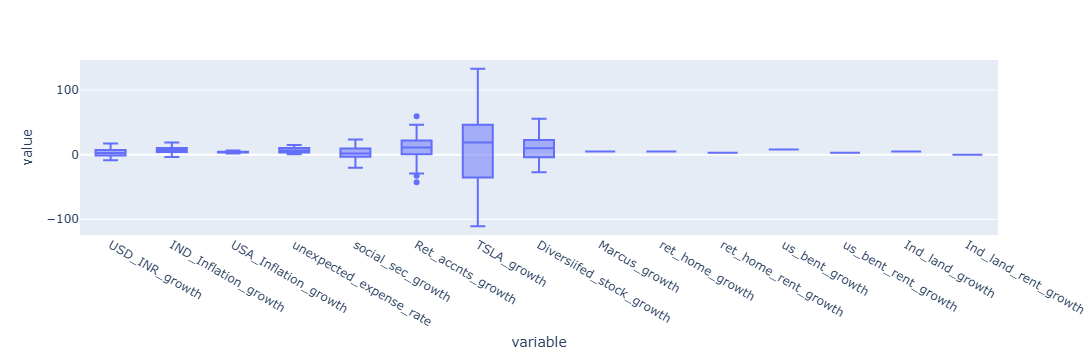

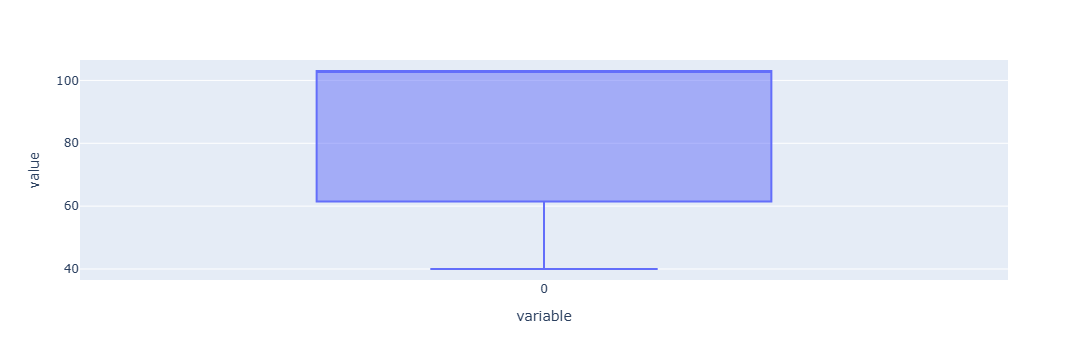

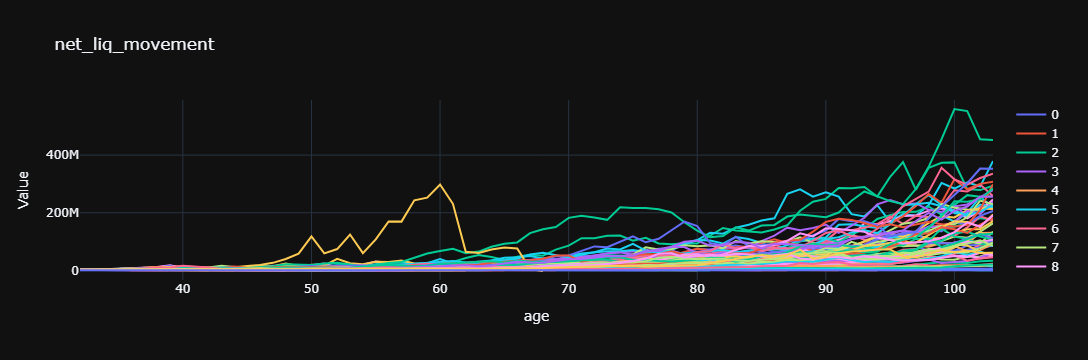

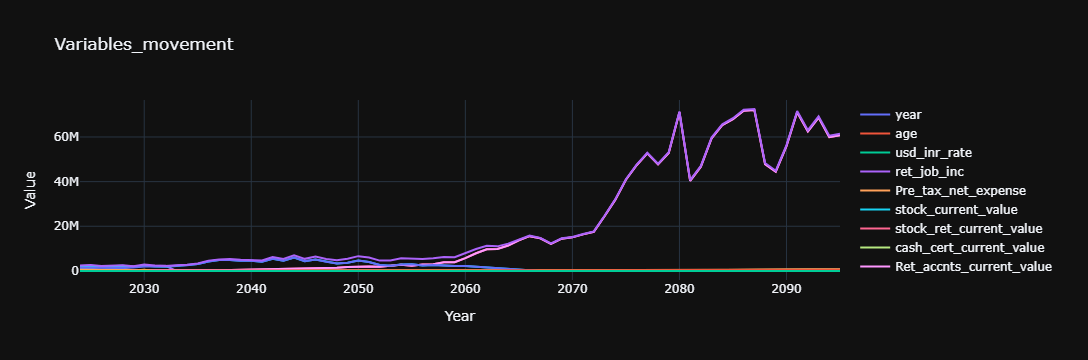

In [8]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px
import requests
from datetime import datetime

# In[2]:

# Age Variables, head of household
year_of_birth = 1992
Age_diff_spouse = 4
retirement_year = 2028
# Investment Variables

# stock market parameters
stock_market_mean_yoy_growthrate_percent = 8
stock_market_std_yoy_growthrate = 18.0977

Investments = {
    'Ret_accnts' :  {
        'type': 'stock_retirement', # pick one from 
        'current_value': 214889,
        'beta': 1,
        'mean_yoy_growthrate_percent': 10.26, 
        'std_yoy_growthrate': 18.0977,
        'additions_yearly' : 0,
        'currency' : 'USD'
    },
    'TSLA' :  {
        'type': 'stock',
        'current_value': 813324,
        'beta': 1,
        'mean_yoy_growthrate_percent': 9, 
        'std_yoy_growthrate': 58.0977, # 18.0977,
        'additions_yearly' : 0,
        'currency' : 'USD'
    },
    'Diversiifed_stock' :  {
        'type': 'stock',
        'current_value': 537598,
        'beta': 1,
        'mean_yoy_growthrate_percent': 10.26, 
        'std_yoy_growthrate': 18.0977,
        'additions_yearly' : 0,
        'currency' : 'USD'
    },
    'Marcus' :  {
        'type': 'cash_certificate',
        'current_value': 20000,
        'additions_yearly' : 0,
        'mean_yoy_growthrate_percent': 5,
        'currency': 'USD'
    },
    'ret_home' : {
        'type': 'real_estate',
        'current_value': 24900000,
        'mean_yoy_growthrate_percent': 5,
        'down_percent': 20,
        'mortgage_term': 30, # Years
        'mortgage_start_year': retirement_year,
        'mortgage_percent': 9.85,
        'closing_costs_onetime': 3500000,
        'currency': 'INR', # Currency of loan
        'rental_income': 0,
        'rental_income_yoy_inc_percent': 3,
        'property_tax_percent': 1.36,
        'HOA_or_maintainance': 2000,
        'home_insurance': 13900,
        'yearly_misc_repair_or_other': 120000
        
    },
    'us_bent' : {
        'type': 'real_estate',
        'current_value': 300000,
        'mean_yoy_growthrate_percent': 7.83,
        'down_percent': 20,
        'mortgage_term': 30, # Years
        'mortgage_start_year': 2025,
        'mortgage_percent': 6.25,
        'closing_costs_onetime': 30000,
        'currency': 'USD',  # Currency of loan
        'rental_income': 1500,
        'rental_income_yoy_inc_percent': 3,
        'property_tax_percent': 1.36,
        'HOA_or_maintainance': 200,
        'home_insurance': 50,
        'yearly_misc_repair_or_other': 1200
    },
    'Ind_land' : {
        'type': 'real_estate',
        'current_value': 5000000,
        'mean_yoy_growthrate_percent': 5,
        'down_percent': 50, 
        'mortgage_term': 15, # Years
        'mortgage_start_year': 2025,
        'mortgage_percent': 6.25,
        'closing_costs_onetime': 500000,
        'currency': 'INR', # Currency of loan
        'rental_income': 0,
        'rental_income_yoy_inc_percent': 0,
        'property_tax_percent': 1.36,
        'HOA_or_maintainance': 10000,
        'home_insurance': 0,
        'yearly_misc_repair_or_other': 0
    }
}

# Handling_social_security 
social_sec = {
        'type': 'social_security',
        'withdrawl_age' : 62,   # Minimum 62 , Max 68
        'inflated_income_per_month' : 2300,  # In USD , as shown in official social sec calculator
        'avg_cola_yoy_growth' : 2.6,
        'avg_cola_std' : 10
}

# USA inflation
USA_inflation_mean = 4
USA_inflation_std = 1

# India Living
Monthly_living = 200000
Monthly_living_currency = 'INR' # USD or INR
India_inflation_mean = 7.379
India_inflation_std = 4.878

# Unexpected expenses percent of living expense
Unexpected_expense_min_percent = 0.5
Unexpected_expense_max_percent = 15

# Post retirement support job
job_income_after_ret_annum = 2000000
job_yoy_increment_percent = 3
job_years_after_ret = 4
job_parameter_curency = 'INR' # USD or INR

# US tax brackets 
US_federal_brackets = [
    (0, 22000, 0.10),
    (22000, 89450, 0.12),
    (89450, 190750, 0.22),
    (190750, 364200, 0.24),
    (364200, 462500, 0.32),
    (462500, 693750, 0.35),
    (693750, 1_000_000, 0.37)
]

US_state_brackets = [
    (0, 20198, 0.01),
    (20198, 47884, 0.02),
    (47884, 75576, 0.04),
    (75576, 104910, 0.06),
    (104910, 132590, 0.08),
    (132590, 677278, 0.093),
    (677278, 812728, 0.103),
    (812728, 1354550, 0.113),
    (1354550, 1_000_000, 0.123)
]

effective_tax_usa = 32
effective_tax_ind = 30

# India tax brackets
India_federal_brackets = [
    (0, 250000, 0.0),
    (250000, 500000, 0.05),
    (500000, 1000000, 0.20),
    (1000000, 10000000, 0.30)
]

# USD to INR rates 
default_USD_to_INR = 83.5 # if live data unavailable
USD_INR_comission_percent = 0.550
USD_INR_mean_growth_percent = 3.040
USD_INR_STD = 5.57

try : 
    response = requests.get("https://api.exchangerate-api.com/v4/latest/USD")
    data = response.json()
    
    # Extracting the USD to INR conversion rate
    USD_INR_rate = data["rates"]["INR"]
except : 
    USD_INR_rate = default_USD_to_INR
    print('unable to reach server to get live USD to INR, using default USD to INR')

current_year = datetime.now().year
target_survival_year = year_of_birth+Age_diff_spouse+100
years_to_calculate = target_survival_year - current_year

# In[3]:
def calculate_mortgage_payment(principal, annual_rate, term_years):
    monthly_rate = annual_rate / 12 / 100
    payments = term_years * 12
    return principal * monthly_rate / (1 - (1 + monthly_rate) ** -payments)

def adjust_rand(generated_values,target_mean,target_std):
    current_mean = np.mean(generated_values)
    current_std = np.std(generated_values)
    if current_std == 0:
        adjusted_values = np.full_like(generated_values, target_mean)
    else:
        adjusted_values = (generated_values - current_mean) / current_std * target_std + target_mean
    return(adjusted_values)

# In[4]:
def gen_simulation_variables():
    rand_var_df = pd.DataFrame()
    rand_var_df['USD_INR_growth'] = adjust_rand(np.random.normal(loc=USD_INR_mean_growth_percent,scale = USD_INR_STD,size = years_to_calculate),USD_INR_mean_growth_percent,USD_INR_STD)
    rand_var_df['IND_Inflation_growth'] = adjust_rand(np.random.normal(loc=India_inflation_mean,scale = India_inflation_std,size = years_to_calculate),India_inflation_mean,India_inflation_std)
    rand_var_df['USA_Inflation_growth'] = adjust_rand(np.random.normal(loc=USA_inflation_mean,scale = USA_inflation_std,size = years_to_calculate),USA_inflation_mean,USA_inflation_std)
    rand_var_df['unexpected_expense_rate'] = np.random.uniform(Unexpected_expense_min_percent, Unexpected_expense_max_percent,size= years_to_calculate)
    rand_var_df['social_sec_growth'] = adjust_rand(np.random.normal(loc=social_sec['avg_cola_yoy_growth'],scale = social_sec['avg_cola_std'],size = years_to_calculate),social_sec['avg_cola_yoy_growth'], social_sec['avg_cola_std'])
    for key,invs in Investments.items(): 
        try: 
            means = invs['mean_yoy_growthrate_percent']
        except: 
            means = 5
        try : 
            std_dev = invs['std_yoy_growthrate']
        except :
            std_dev = 0
        rand_var_df[f'{key}_growth'] = adjust_rand(np.random.normal(loc=means,scale = std_dev,size = years_to_calculate),means,std_dev)

        if invs['type'] == 'real_estate':
            rand_var_df[f'{key}_rent_growth'] = adjust_rand(np.random.normal(loc= invs['rental_income_yoy_inc_percent'],scale = 0,size = years_to_calculate),invs['rental_income_yoy_inc_percent'],0)

    return rand_var_df

# In[5]:
def simulate_retirement(simulation_var_df):
    simulation_var_df['year'] =  current_year + simulation_var_df.index
    simulation_var_df['age'] = current_year + simulation_var_df.index - year_of_birth
    for sim_year in simulation_var_df.index: 
        if sim_year == 0:
            simulation_var_df.loc[sim_year,'usd_inr_rate'] = USD_INR_rate
        else : 
            simulation_var_df.loc[sim_year,'usd_inr_rate'] = simulation_var_df.loc[sim_year-1,'usd_inr_rate']*(1+simulation_var_df.loc[sim_year,'USD_INR_growth']/100)

        try : 
            simulation_var_df.loc[sim_year,'inflated_living'] = simulation_var_df.loc[sim_year-1,'inflated_living'] * (1+ (simulation_var_df.loc[sim_year-1,'IND_Inflation_growth'])/100)
        except: 
            simulation_var_df.loc[sim_year,'inflated_living'] = Monthly_living

        if simulation_var_df.loc[sim_year,'year'] < retirement_year: 
            simulation_var_df.loc[sim_year,'living_expense'] =0
            simulation_var_df.loc[sim_year,'unexpected_expense'] = 0
        else :
            simulation_var_df.loc[sim_year,'living_expense'] = simulation_var_df.loc[sim_year,'inflated_living']*12
            simulation_var_df.loc[sim_year,'unexpected_expense'] =  simulation_var_df.loc[sim_year,'living_expense']* (simulation_var_df.loc[sim_year,'unexpected_expense_rate']/100)

        if (simulation_var_df.loc[sim_year,'year'] < retirement_year) or (simulation_var_df.loc[sim_year,'year'] > retirement_year + job_years_after_ret) : 
            simulation_var_df.loc[sim_year,'ret_job_inc'] = 0
        elif simulation_var_df.loc[sim_year,'year'] == retirement_year:
            simulation_var_df.loc[sim_year,'ret_job_inc'] = job_income_after_ret_annum 
        else :
            simulation_var_df.loc[sim_year,'ret_job_inc'] = simulation_var_df.loc[sim_year -1 ,'ret_job_inc']* (1+job_yoy_increment_percent/100)

        simulation_var_df.loc[sim_year,'post_tax_living_USD_needed'] = (simulation_var_df.loc[sim_year,'living_expense'] +simulation_var_df.loc[sim_year,'unexpected_expense'] - simulation_var_df.loc[sim_year,'ret_job_inc'])/simulation_var_df.loc[sim_year,'usd_inr_rate']

        simulation_var_df.loc[sim_year,'post_tax_all_mortgage'] = 0
        for key,invs in Investments.items(): 
            if invs['type'] == 'real_estate':
                if (simulation_var_df.loc[sim_year,'year'] < invs['mortgage_start_year'])or(simulation_var_df.loc[sim_year,'year'] > invs['mortgage_start_year']+invs['mortgage_term']) :
                    simulation_var_df.loc[sim_year,f'{key}_base_mortgage'] = 0
                else : 
                    simulation_var_df.loc[sim_year,f'{key}_base_mortgage'] = calculate_mortgage_payment(invs['current_value']*(1-invs['down_percent']/100),invs['mortgage_percent'],invs['mortgage_term'])*12

                if simulation_var_df.loc[sim_year,'year'] <= invs['mortgage_start_year']:
                    simulation_var_df.loc[sim_year,f'{key}_inflated'] = invs['yearly_misc_repair_or_other']+ invs['HOA_or_maintainance']
                elif invs['currency'] == 'USD':
                    simulation_var_df.loc[sim_year,f'{key}_inflated'] = simulation_var_df.loc[sim_year-1,f'{key}_inflated'] * (1+simulation_var_df.loc[sim_year,'USA_Inflation_growth']/100)
                else : 
                    simulation_var_df.loc[sim_year,f'{key}_inflated'] = simulation_var_df.loc[sim_year-1,f'{key}_inflated'] * (1+simulation_var_df.loc[sim_year,'IND_Inflation_growth']/100)

                if simulation_var_df.loc[sim_year,'year'] <= invs['mortgage_start_year']:
                    simulation_var_df.loc[sim_year,f'{key}_rent_inflated'] = invs['rental_income']
                else: 
                    simulation_var_df.loc[sim_year,f'{key}_rent_inflated'] = simulation_var_df.loc[sim_year-1,f'{key}_rent_inflated']*(1+simulation_var_df.loc[sim_year,f'{key}_rent_growth']/100)

                if simulation_var_df.loc[sim_year,'year'] < invs['mortgage_start_year']:
                    simulation_var_df.loc[sim_year,f'{key}_mortgage'] = 0
                else: 
                    if simulation_var_df.loc[sim_year,'year'] == invs['mortgage_start_year']:
                        simulation_var_df.loc[sim_year,f'{key}_one_time_mortgage'] = (invs['down_percent']*invs['current_value']/100)+ invs['closing_costs_onetime']
                    else : 
                        simulation_var_df.loc[sim_year,f'{key}_one_time_mortgage'] = 0
                    simulation_var_df.loc[sim_year,f'{key}_mortgage'] = simulation_var_df.loc[sim_year,f'{key}_base_mortgage'] + invs['current_value']*(invs['property_tax_percent']/100)+invs['home_insurance']+simulation_var_df.loc[sim_year,f'{key}_inflated'] + simulation_var_df.loc[sim_year,f'{key}_one_time_mortgage'] - simulation_var_df.loc[sim_year,f'{key}_rent_inflated']
                    if invs['currency'] == 'INR':
                        simulation_var_df.loc[sim_year,f'{key}_mortgage'] = simulation_var_df.loc[sim_year,f'{key}_mortgage']/simulation_var_df.loc[sim_year,'usd_inr_rate']

                simulation_var_df.loc[sim_year,'post_tax_all_mortgage'] += simulation_var_df.loc[sim_year,f'{key}_mortgage']

        simulation_var_df.loc[sim_year,'post_tax_net_expense'] = simulation_var_df.loc[sim_year,'post_tax_all_mortgage']+simulation_var_df.loc[sim_year,'post_tax_living_USD_needed']

        if simulation_var_df.loc[sim_year,'year'] <= retirement_year+2:
            simulation_var_df.loc[sim_year,'Pre_tax_net_expense'] = simulation_var_df.loc[sim_year,'post_tax_net_expense'] / (1 - effective_tax_usa / 100) if effective_tax_usa != 0 else simulation_var_df.loc[sim_year,'post_tax_net_expense']
        else : 
            simulation_var_df.loc[sim_year,'Pre_tax_net_expense'] = simulation_var_df.loc[sim_year,'post_tax_net_expense'] / (1 - effective_tax_ind / 100) if effective_tax_usa != 0 else simulation_var_df.loc[sim_year,'post_tax_net_expense']

        simulation_var_df.loc[sim_year,'stock_current_value'] = 0
        simulation_var_df.loc[sim_year,'stock_ret_current_value'] = 0
        simulation_var_df.loc[sim_year,'cash_cert_current_value'] = 0
        for key,invsts in Investments.items():
            if invsts['type'] in ['stock','stock_retirement','cash_certificate']:
                if sim_year == 0 :
                    simulation_var_df.loc[sim_year,f'{key}_current_value'] = invsts['current_value']
                else : 
                    simulation_var_df.loc[sim_year,f'{key}_current_value'] = simulation_var_df.loc[sim_year -1 ,f'{key}_current_value'] * ( 1 + (simulation_var_df.loc[sim_year -1 ,f'{key}_growth']/100))
                if invsts['type'] == 'stock' :
                    simulation_var_df.loc[sim_year,'stock_current_value'] += simulation_var_df.loc[sim_year,f'{key}_current_value']
                if invsts['type'] == 'stock_retirement' :
                    simulation_var_df.loc[sim_year,'stock_ret_current_value'] += simulation_var_df.loc[sim_year,f'{key}_current_value']
                if invsts['type'] == 'cash_certificate' :
                    simulation_var_df.loc[sim_year,'cash_cert_current_value'] += simulation_var_df.loc[sim_year,f'{key}_current_value']

        simulation_var_df.loc[sim_year,'Pre_tax_expense_left'] =  simulation_var_df.loc[sim_year,'Pre_tax_net_expense']*1

        if simulation_var_df.loc[sim_year,'year'] >= social_sec['withdrawl_age']+ year_of_birth:
            simulation_var_df.loc[sim_year,'Pre_tax_expense_left'] -= social_sec['inflated_income_per_month']*12

        inv_rat = {}
        if (simulation_var_df.loc[sim_year,'Pre_tax_expense_left'] > 0)  and (simulation_var_df.loc[sim_year,'stock_current_value'] > 0):  
            for key,invsts in Investments.items():
                if invsts['type'] == 'stock':
                    inv_rat[f'{key}'] = simulation_var_df.loc[sim_year ,f'{key}_current_value'] / simulation_var_df.loc[sim_year,'stock_current_value']
            if simulation_var_df.loc[sim_year,'Pre_tax_expense_left'] <= simulation_var_df.loc[sim_year,'stock_current_value']:  
                simulation_var_df.loc[sim_year,'stock_current_value'] -= simulation_var_df.loc[sim_year,'Pre_tax_expense_left']
                simulation_var_df.loc[sim_year,'Pre_tax_expense_left'] = 0
            else: 
                simulation_var_df.loc[sim_year,'Pre_tax_expense_left'] -= simulation_var_df.loc[sim_year,'stock_current_value']
                simulation_var_df.loc[sim_year,'stock_current_value'] = 0
            for key,invsts in Investments.items():
                if invsts['type'] == 'stock' :
                    simulation_var_df.loc[sim_year ,f'{key}_current_value'] = inv_rat[f'{key}']*simulation_var_df.loc[sim_year,'stock_current_value']

        if (simulation_var_df.loc[sim_year,'Pre_tax_expense_left'] > 0)  and (simulation_var_df.loc[sim_year,'stock_ret_current_value'] > 0):  
            if simulation_var_df.loc[sim_year,'age'] >= 58: 
                penalty_withdraw_multiplier = 1
            else: 
                penalty_withdraw_multiplier = 1.1
            for key,invsts in Investments.items():
                if invsts['type'] == 'stock_retirement':
                    inv_rat[f'{key}'] = simulation_var_df.loc[sim_year ,f'{key}_current_value'] / simulation_var_df.loc[sim_year,'stock_ret_current_value']
            if simulation_var_df.loc[sim_year,'Pre_tax_expense_left']*penalty_withdraw_multiplier <= simulation_var_df.loc[sim_year,'stock_ret_current_value']:  
                simulation_var_df.loc[sim_year,'stock_ret_current_value'] -= simulation_var_df.loc[sim_year,'Pre_tax_expense_left']*penalty_withdraw_multiplier
                simulation_var_df.loc[sim_year,'Pre_tax_expense_left'] = 0
            else: 
                simulation_var_df.loc[sim_year,'Pre_tax_expense_left'] -= simulation_var_df.loc[sim_year,'stock_ret_current_value']*penalty_withdraw_multiplier
                simulation_var_df.loc[sim_year,'stock_ret_current_value'] = 0
            for key,invsts in Investments.items():
                if invsts['type'] == 'stock_retirement' :
                    simulation_var_df.loc[sim_year ,f'{key}_current_value'] = inv_rat[f'{key}']*simulation_var_df.loc[sim_year,'stock_ret_current_value']

        if (simulation_var_df.loc[sim_year,'Pre_tax_expense_left'] > 0)  and (simulation_var_df.loc[sim_year,'cash_cert_current_value'] > 0):
            for key,invsts in Investments.items():
                if invsts['type'] == 'cash_certificate':
                    inv_rat[f'{key}'] = simulation_var_df.loc[sim_year ,f'{key}_current_value'] / simulation_var_df.loc[sim_year,'cash_cert_current_value']
            if simulation_var_df.loc[sim_year,'Pre_tax_expense_left'] <= simulation_var_df.loc[sim_year,'cash_cert_current_value']:  
                simulation_var_df.loc[sim_year,'cash_cert_current_value'] -= simulation_var_df.loc[sim_year,'Pre_tax_expense_left']
                simulation_var_df.loc[sim_year,'Pre_tax_expense_left'] = 0
            else: 
                simulation_var_df.loc[sim_year,'Pre_tax_expense_left'] -= simulation_var_df.loc[sim_year,'cash_cert_current_value']
                simulation_var_df.loc[sim_year,'cash_cert_current_value'] = 0
            for key,invsts in Investments.items():
                if invsts['type'] == 'cash_certificate' :
                    simulation_var_df.loc[sim_year ,f'{key}_current_value'] = inv_rat[f'{key}']*simulation_var_df.loc[sim_year,'cash_cert_current_value']

        simulation_var_df.loc[sim_year,'Net_liquid_left'] = simulation_var_df.loc[sim_year,'stock_current_value'] +simulation_var_df.loc[sim_year,'stock_ret_current_value'] + simulation_var_df.loc[sim_year,'cash_cert_current_value']
        if simulation_var_df.loc[sim_year,'Net_liquid_left'] <= 0 : 
            return simulation_var_df.loc[sim_year,'age'],simulation_var_df
            
    return simulation_var_df.loc[sim_year,'age'],simulation_var_df

# In[6]:
def clean_summary_df(simulation_var_df): 
    summary_df = simulation_var_df.copy()
    summary_df.drop([col for col in summary_df.columns if col.endswith('_growth')], axis=1, inplace = True)
    summary_df.drop([col for col in summary_df.columns if col.endswith('_inflated')], axis=1, inplace = True)
    summary_df.drop([col for col in summary_df.columns if col.endswith('_one_time_mortgage')], axis=1, inplace = True)
    summary_df.drop([col for col in summary_df.columns if col.endswith('_base_mortgage')], axis=1, inplace = True)
    summary_df.drop([col for col in summary_df.columns if col.endswith('_mortgage')], axis=1, inplace = True)
    summary_df.drop([col for col in summary_df.columns if col.startswith('post_tax')], axis=1, inplace = True)
    summary_df.drop('inflated_living', axis=1, inplace=True)
    summary_df.drop('unexpected_expense_rate', axis=1, inplace=True)
    summary_df.drop('living_expense', axis=1, inplace=True)
    summary_df.drop('unexpected_expense', axis=1, inplace=True)
    return summary_df

# In[7]:

simualtion_counts = 100
broke_ages = []
net_liq_results = []  # Collect results in a list instead of assigning columns repeatedly

Investments['Diversiifed_stock']['current_value'] = 1400000

realistic_target_survival_age = 100 

for i in range(simualtion_counts): 
    rand_var_df = gen_simulation_variables()
    broke_age,simulation_var_df = simulate_retirement(rand_var_df.copy())
    broke_ages.append(broke_age)
    # Store each run's Net_liquid_left in a list, then we'll concat at the end
    net_liq_results.append(simulation_var_df['Net_liquid_left'].rename(i))

net_liq = pd.concat(net_liq_results, axis=1)
net_liq['age'] = simulation_var_df['age']
print('min_broke_age=',np.min(broke_ages),'mean_broke_age=',np.mean(broke_ages),'std_broke_age=',np.std(broke_ages),'broke_age_failure=',sum(1 for age in broke_ages if age < (realistic_target_survival_age )) * 100 / simualtion_counts)

random_var_box = px.box(rand_var_df)
random_var_box.show()
broke_age_box = px.box(broke_ages)
broke_age_box.show()

liq = go.Figure()
for column in net_liq.columns:
    liq.add_trace(go.Scatter(x=net_liq['age'], y=net_liq[column], mode='lines', name=column))

liq.update_layout(
    title='net_liq_movement',
    xaxis_title='age',
    yaxis_title='Value',
    template='plotly_dark'
)
liq.show()

# In[8]:
summary_df = clean_summary_df(simulation_var_df)
fig = go.Figure()
for column in summary_df.columns:
    fig.add_trace(go.Scatter(x=summary_df['year'], y=summary_df[column], mode='lines', name=column))

fig.update_layout(
    title='Variables_movement',
    xaxis_title='Year',
    yaxis_title='Value',
    template='plotly_dark'
)
fig.show()


min_broke_age= 39 mean_broke_age= 83.14 std_broke_age= 23.256835554305322 broke_age_failure= 46.0


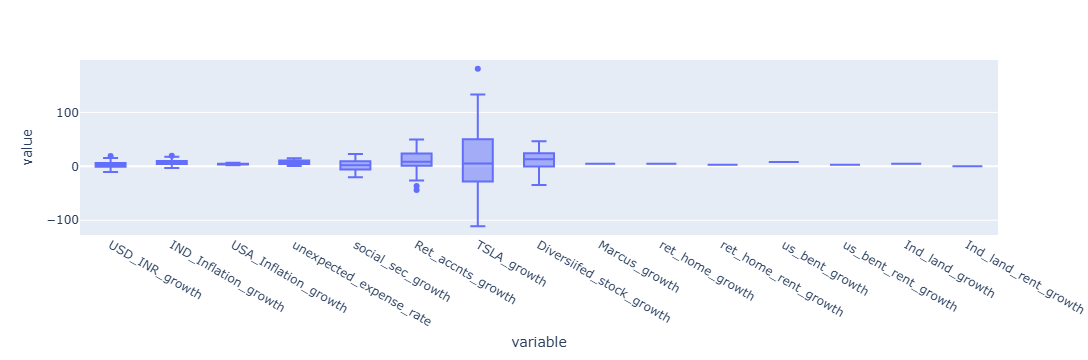

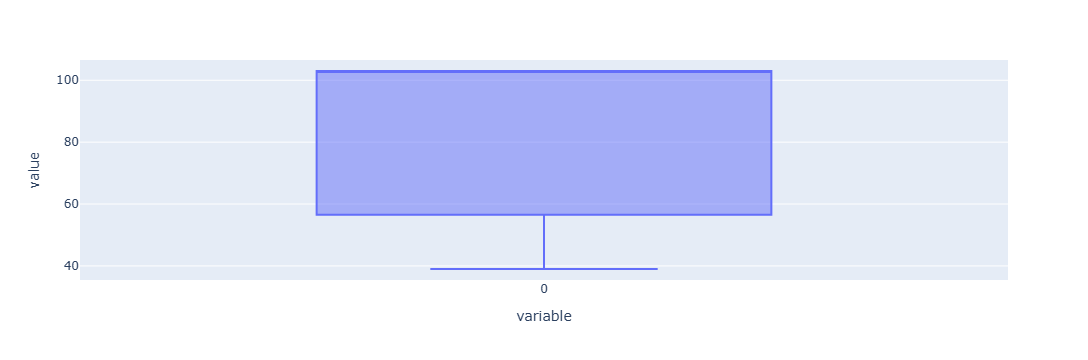

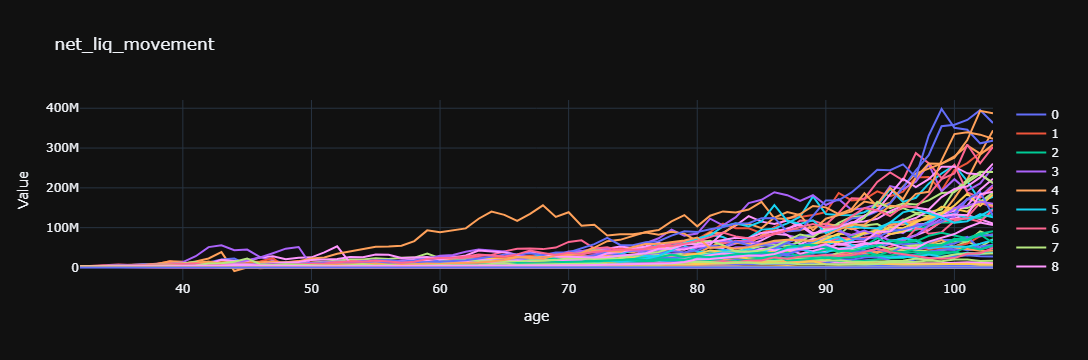

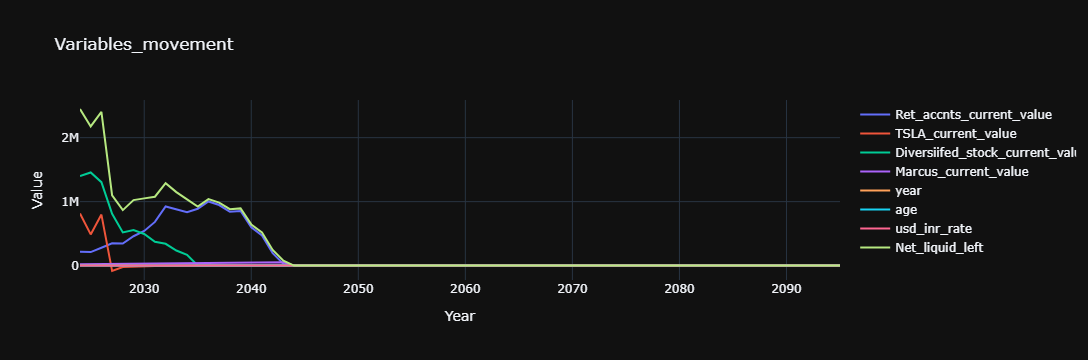

In [10]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px
import requests
from datetime import datetime

# Original configuration and setup variables
year_of_birth = 1992
Age_diff_spouse = 4
retirement_year = 2028

stock_market_mean_yoy_growthrate_percent = 8
stock_market_std_yoy_growthrate = 18.0977

Investments = {
    'Ret_accnts': {
        'type': 'stock_retirement',
        'current_value': 214889,
        'beta': 1,
        'mean_yoy_growthrate_percent': 10.26,
        'std_yoy_growthrate': 18.0977,
        'additions_yearly': 0,
        'currency': 'USD'
    },
    'TSLA': {
        'type': 'stock',
        'current_value': 813324,
        'beta': 1,
        'mean_yoy_growthrate_percent': 9,
        'std_yoy_growthrate': 58.0977,
        'additions_yearly': 0,
        'currency': 'USD'
    },
    'Diversiifed_stock': {
        'type': 'stock',
        'current_value': 537598,
        'beta': 1,
        'mean_yoy_growthrate_percent': 10.26,
        'std_yoy_growthrate': 18.0977,
        'additions_yearly': 0,
        'currency': 'USD'
    },
    'Marcus': {
        'type': 'cash_certificate',
        'current_value': 20000,
        'additions_yearly': 0,
        'mean_yoy_growthrate_percent': 5,
        'currency': 'USD'
    },
    'ret_home': {
        'type': 'real_estate',
        'current_value': 24900000,
        'mean_yoy_growthrate_percent': 5,
        'down_percent': 20,
        'mortgage_term': 30,
        'mortgage_start_year': retirement_year,
        'mortgage_percent': 9.85,
        'closing_costs_onetime': 3500000,
        'currency': 'INR',
        'rental_income': 0,
        'rental_income_yoy_inc_percent': 3,
        'property_tax_percent': 1.36,
        'HOA_or_maintainance': 2000,
        'home_insurance': 13900,
        'yearly_misc_repair_or_other': 120000
    },
    'us_bent': {
        'type': 'real_estate',
        'current_value': 300000,
        'mean_yoy_growthrate_percent': 7.83,
        'down_percent': 20,
        'mortgage_term': 30,
        'mortgage_start_year': 2025,
        'mortgage_percent': 6.25,
        'closing_costs_onetime': 30000,
        'currency': 'USD',
        'rental_income': 1500,
        'rental_income_yoy_inc_percent': 3,
        'property_tax_percent': 1.36,
        'HOA_or_maintainance': 200,
        'home_insurance': 50,
        'yearly_misc_repair_or_other': 1200
    },
    'Ind_land': {
        'type': 'real_estate',
        'current_value': 5000000,
        'mean_yoy_growthrate_percent': 5,
        'down_percent': 50,
        'mortgage_term': 15,
        'mortgage_start_year': 2025,
        'mortgage_percent': 6.25,
        'closing_costs_onetime': 500000,
        'currency': 'INR',
        'rental_income': 0,
        'rental_income_yoy_inc_percent': 0,
        'property_tax_percent': 1.36,
        'HOA_or_maintainance': 10000,
        'home_insurance': 0,
        'yearly_misc_repair_or_other': 0
    }
}

social_sec = {
    'type': 'social_security',
    'withdrawl_age': 62,
    'inflated_income_per_month': 2300,
    'avg_cola_yoy_growth': 2.6,
    'avg_cola_std': 10
}

USA_inflation_mean = 4
USA_inflation_std = 1
Monthly_living = 200000
Monthly_living_currency = 'INR'
India_inflation_mean = 7.379
India_inflation_std = 4.878
Unexpected_expense_min_percent = 0.5
Unexpected_expense_max_percent = 15

job_income_after_ret_annum = 2000000
job_yoy_increment_percent = 3
job_years_after_ret = 4
job_parameter_curency = 'INR'

US_federal_brackets = [
    (0, 22000, 0.10),
    (22000, 89450, 0.12),
    (89450, 190750, 0.22),
    (190750, 364200, 0.24),
    (364200, 462500, 0.32),
    (462500, 693750, 0.35),
    (693750, 1_000_000, 0.37)
]

US_state_brackets = [
    (0, 20198, 0.01),
    (20198, 47884, 0.02),
    (47884, 75576, 0.04),
    (75576, 104910, 0.06),
    (104910, 132590, 0.08),
    (132590, 677278, 0.093),
    (677278, 812728, 0.103),
    (812728, 1354550, 0.113),
    (1354550, 1_000_000, 0.123)
]

effective_tax_usa = 32
effective_tax_ind = 30

India_federal_brackets = [
    (0, 250000, 0.0),
    (250000, 500000, 0.05),
    (500000, 1000000, 0.20),
    (1000000, 10000000, 0.30)
]

default_USD_to_INR = 83.5
USD_INR_comission_percent = 0.550
USD_INR_mean_growth_percent = 3.040
USD_INR_STD = 5.57

try:
    response = requests.get("https://api.exchangerate-api.com/v4/latest/USD")
    data = response.json()
    USD_INR_rate = data["rates"]["INR"]
except:
    USD_INR_rate = default_USD_to_INR
    print('unable to reach server to get live USD to INR, using default USD to INR')

current_year = datetime.now().year
target_survival_year = year_of_birth + Age_diff_spouse + 100
years_to_calculate = target_survival_year - current_year

def calculate_mortgage_payment(principal, annual_rate, term_years):
    monthly_rate = annual_rate / 12 / 100
    payments = term_years * 12
    return principal * monthly_rate / (1 - (1 + monthly_rate) ** -payments)

def adjust_rand(generated_values, target_mean, target_std):
    current_mean = np.mean(generated_values)
    current_std = np.std(generated_values)
    if current_std == 0:
        return np.full_like(generated_values, target_mean)
    return (generated_values - current_mean) / current_std * target_std + target_mean

def gen_simulation_variables():
    rand_var_df = pd.DataFrame()
    rand_var_df['USD_INR_growth'] = adjust_rand(np.random.normal(loc=USD_INR_mean_growth_percent,scale = USD_INR_STD,size = years_to_calculate),USD_INR_mean_growth_percent,USD_INR_STD)
    rand_var_df['IND_Inflation_growth'] = adjust_rand(np.random.normal(loc=India_inflation_mean,scale = India_inflation_std,size = years_to_calculate),India_inflation_mean,India_inflation_std)
    rand_var_df['USA_Inflation_growth'] = adjust_rand(np.random.normal(loc=USA_inflation_mean,scale = USA_inflation_std,size = years_to_calculate),USA_inflation_mean,USA_inflation_std)
    rand_var_df['unexpected_expense_rate'] = np.random.uniform(Unexpected_expense_min_percent, Unexpected_expense_max_percent,size= years_to_calculate)
    rand_var_df['social_sec_growth'] = adjust_rand(np.random.normal(loc=social_sec['avg_cola_yoy_growth'],scale = social_sec['avg_cola_std'],size = years_to_calculate),social_sec['avg_cola_yoy_growth'], social_sec['avg_cola_std'])

    for key,invs in Investments.items():
        means = invs.get('mean_yoy_growthrate_percent',5)
        std_dev = invs.get('std_yoy_growthrate',0)
        rand_var_df[f'{key}_growth'] = adjust_rand(np.random.normal(loc=means,scale = std_dev,size = years_to_calculate),means,std_dev)

        if invs['type'] == 'real_estate':
            rand_var_df[f'{key}_rent_growth'] = adjust_rand(np.random.normal(loc= invs['rental_income_yoy_inc_percent'],scale = 0,size = years_to_calculate),invs['rental_income_yoy_inc_percent'],0)

    return rand_var_df

def simulate_retirement(simulation_var_df):
    # Pre-extract arrays for repeated usage
    year_arr = current_year + simulation_var_df.index.values
    age_arr = year_arr - year_of_birth

    # Initialize arrays for each column we set
    usd_inr_rate_arr = np.zeros(years_to_calculate)
    inflated_living_arr = np.zeros(years_to_calculate)
    living_expense_arr = np.zeros(years_to_calculate)
    unexpected_expense_arr = np.zeros(years_to_calculate)
    ret_job_inc_arr = np.zeros(years_to_calculate)
    post_tax_living_USD_needed_arr = np.zeros(years_to_calculate)
    post_tax_all_mortgage_arr = np.zeros(years_to_calculate)
    post_tax_net_expense_arr = np.zeros(years_to_calculate)
    Pre_tax_net_expense_arr = np.zeros(years_to_calculate)
    stock_current_value_arr = np.zeros(years_to_calculate)
    stock_ret_current_value_arr = np.zeros(years_to_calculate)
    cash_cert_current_value_arr = np.zeros(years_to_calculate)
    Pre_tax_expense_left_arr = np.zeros(years_to_calculate)
    Net_liquid_left_arr = np.zeros(years_to_calculate)

    # We also need arrays for dynamically created columns like per real estate investment
    # We'll store them in dictionaries keyed by investment name
    base_mortgage_dict = {}
    inflated_dict = {}
    rent_inflated_dict = {}
    one_time_mortgage_dict = {}
    mortgage_dict = {}

    for key, invs in Investments.items():
        if invs['type'] == 'real_estate':
            base_mortgage_dict[key] = np.zeros(years_to_calculate)
            inflated_dict[key] = np.zeros(years_to_calculate)
            rent_inflated_dict[key] = np.zeros(years_to_calculate)
            one_time_mortgage_dict[key] = np.zeros(years_to_calculate)
            mortgage_dict[key] = np.zeros(years_to_calculate)
        if invs['type'] in ['stock','stock_retirement','cash_certificate']:
            # Initialize investment current_value arrays if needed
            simulation_var_df[f'{key}_current_value'] = np.zeros(years_to_calculate)

    # Convert used columns from simulation_var_df to arrays for direct indexing
    USD_INR_growth_arr = simulation_var_df['USD_INR_growth'].values
    IND_Inflation_growth_arr = simulation_var_df['IND_Inflation_growth'].values
    USA_Inflation_growth_arr = simulation_var_df['USA_Inflation_growth'].values
    unexpected_expense_rate_arr = simulation_var_df['unexpected_expense_rate'].values

    # For each real estate that has rent_growth
    re_rent_growth_data = {}
    for key,invs in Investments.items():
        if invs['type'] == 'real_estate':
            re_rent_growth_data[key] = simulation_var_df[f'{key}_rent_growth'].values

    # For each investment growth
    inv_growth_data = {}
    for key, invs in Investments.items():
        inv_growth_data[key] = simulation_var_df[f'{key}_growth'].values

    # Main simulation loop - same logic as original, but using arrays
    for sim_year in range(years_to_calculate):
        if sim_year == 0:
            usd_inr_rate_arr[sim_year] = USD_INR_rate
        else:
            usd_inr_rate_arr[sim_year] = usd_inr_rate_arr[sim_year-1]*(1+USD_INR_growth_arr[sim_year]/100)

        # inflated_living
        if sim_year == 0:
            inflated_living_arr[sim_year] = Monthly_living
        else:
            inflated_living_arr[sim_year] = inflated_living_arr[sim_year-1]*(1+(IND_Inflation_growth_arr[sim_year-1]/100))

        if year_arr[sim_year] < retirement_year:
            living_expense_arr[sim_year] = 0
            unexpected_expense_arr[sim_year] = 0
        else:
            living_expense_arr[sim_year] = inflated_living_arr[sim_year]*12
            unexpected_expense_arr[sim_year] = living_expense_arr[sim_year]*(unexpected_expense_rate_arr[sim_year]/100)

        if (year_arr[sim_year] < retirement_year) or (year_arr[sim_year] > retirement_year + job_years_after_ret):
            ret_job_inc_arr[sim_year] = 0
        elif year_arr[sim_year] == retirement_year:
            ret_job_inc_arr[sim_year] = job_income_after_ret_annum
        else:
            ret_job_inc_arr[sim_year] = ret_job_inc_arr[sim_year-1]*(1+job_yoy_increment_percent/100)

        post_tax_living_USD_needed_arr[sim_year] = (living_expense_arr[sim_year] + unexpected_expense_arr[sim_year] - ret_job_inc_arr[sim_year])/usd_inr_rate_arr[sim_year]

        # Calculate mortgages
        post_tax_all_mortgage_arr[sim_year] = 0
        for key, invs in Investments.items():
            if invs['type'] == 'real_estate':
                if (year_arr[sim_year] < invs['mortgage_start_year']) or (year_arr[sim_year] > invs['mortgage_start_year']+invs['mortgage_term']):
                    base_mortgage_dict[key][sim_year] = 0
                else:
                    base_mortgage_dict[key][sim_year] = calculate_mortgage_payment(invs['current_value']*(1-invs['down_percent']/100),invs['mortgage_percent'],invs['mortgage_term'])*12

                if year_arr[sim_year] <= invs['mortgage_start_year']:
                    inflated_dict[key][sim_year] = invs['yearly_misc_repair_or_other']+ invs['HOA_or_maintainance']
                else:
                    # Check currency for inflation
                    if invs['currency'] == 'USD':
                        inflated_dict[key][sim_year] = inflated_dict[key][sim_year-1]*(1+USA_Inflation_growth_arr[sim_year]/100)
                    else:
                        inflated_dict[key][sim_year] = inflated_dict[key][sim_year-1]*(1+IND_Inflation_growth_arr[sim_year]/100)

                if year_arr[sim_year] <= invs['mortgage_start_year']:
                    rent_inflated_dict[key][sim_year] = invs['rental_income']
                else:
                    rent_inflated_dict[key][sim_year] = rent_inflated_dict[key][sim_year-1]*(1+re_rent_growth_data[key][sim_year]/100)

                if year_arr[sim_year] < invs['mortgage_start_year']:
                    mortgage_dict[key][sim_year] = 0
                    one_time_mortgage_dict[key][sim_year] = 0
                else:
                    if year_arr[sim_year] == invs['mortgage_start_year']:
                        one_time_mortgage_dict[key][sim_year] = (invs['down_percent']*invs['current_value']/100)+ invs['closing_costs_onetime']
                    else:
                        one_time_mortgage_dict[key][sim_year] = 0
                    val = base_mortgage_dict[key][sim_year] + invs['current_value']*(invs['property_tax_percent']/100) + invs['home_insurance'] + inflated_dict[key][sim_year] + one_time_mortgage_dict[key][sim_year] - rent_inflated_dict[key][sim_year]
                    if invs['currency'] == 'INR':
                        val = val/usd_inr_rate_arr[sim_year]
                    mortgage_dict[key][sim_year] = val

                post_tax_all_mortgage_arr[sim_year] += mortgage_dict[key][sim_year]

        post_tax_net_expense_arr[sim_year] = post_tax_all_mortgage_arr[sim_year] + post_tax_living_USD_needed_arr[sim_year]

        # Pre tax expense
        if year_arr[sim_year] <= retirement_year+2:
            if effective_tax_usa != 0:
                Pre_tax_net_expense_arr[sim_year] = post_tax_net_expense_arr[sim_year]/(1 - effective_tax_usa/100)
            else:
                Pre_tax_net_expense_arr[sim_year] = post_tax_net_expense_arr[sim_year]
        else:
            if effective_tax_ind != 0:
                Pre_tax_net_expense_arr[sim_year] = post_tax_net_expense_arr[sim_year]/(1 - effective_tax_ind/100)
            else:
                Pre_tax_net_expense_arr[sim_year] = post_tax_net_expense_arr[sim_year]

        # Update investments
        for key,invsts in Investments.items():
            if invsts['type'] in ['stock','stock_retirement','cash_certificate']:
                if sim_year == 0:
                    simulation_var_df.at[sim_year, f'{key}_current_value'] = invsts['current_value']
                else:
                    simulation_var_df.at[sim_year, f'{key}_current_value'] = simulation_var_df.at[sim_year -1 ,f'{key}_current_value'] * (1+(inv_growth_data[key][sim_year -1]/100))

        # Sum up current values
        stock_val = 0
        stock_ret_val = 0
        cash_cert_val = 0
        for key,invsts in Investments.items():
            if invsts['type'] == 'stock':
                stock_val += simulation_var_df.at[sim_year,f'{key}_current_value']
            elif invsts['type'] == 'stock_retirement':
                stock_ret_val += simulation_var_df.at[sim_year,f'{key}_current_value']
            elif invsts['type'] == 'cash_certificate':
                cash_cert_val += simulation_var_df.at[sim_year,f'{key}_current_value']

        stock_current_value_arr[sim_year] = stock_val
        stock_ret_current_value_arr[sim_year] = stock_ret_val
        cash_cert_current_value_arr[sim_year] = cash_cert_val

        Pre_tax_expense_left_arr[sim_year] = Pre_tax_net_expense_arr[sim_year]*1

        if year_arr[sim_year] >= social_sec['withdrawl_age']+ year_of_birth:
            Pre_tax_expense_left_arr[sim_year] -= social_sec['inflated_income_per_month']*12

        inv_rat = {}
        # Withdraw from stocks
        if (Pre_tax_expense_left_arr[sim_year] > 0) and (stock_current_value_arr[sim_year] > 0):
            # Calculate ratio
            for key,invsts in Investments.items():
                if invsts['type'] == 'stock':
                    inv_rat[key] = simulation_var_df.at[sim_year,f'{key}_current_value']/stock_current_value_arr[sim_year]
            if Pre_tax_expense_left_arr[sim_year] <= stock_current_value_arr[sim_year]:
                # Partial withdrawal
                reduce_ratio = Pre_tax_expense_left_arr[sim_year]/stock_current_value_arr[sim_year]
                stock_current_value_arr[sim_year] -= Pre_tax_expense_left_arr[sim_year]
                Pre_tax_expense_left_arr[sim_year] = 0
            else:
                # Take all stock
                Pre_tax_expense_left_arr[sim_year] -= stock_current_value_arr[sim_year]
                stock_current_value_arr[sim_year] = 0
                reduce_ratio = 1

            for key,invsts in Investments.items():
                if invsts['type'] == 'stock':
                    simulation_var_df.at[sim_year,f'{key}_current_value'] = simulation_var_df.at[sim_year,f'{key}_current_value']*(1-reduce_ratio)

        # Withdraw from retirement stocks
        if (Pre_tax_expense_left_arr[sim_year] > 0) and (stock_ret_current_value_arr[sim_year] > 0):
            if age_arr[sim_year] >= 58:
                penalty_withdraw_multiplier = 1
            else:
                penalty_withdraw_multiplier = 1.1

            for key,invsts in Investments.items():
                if invsts['type'] == 'stock_retirement':
                    inv_rat[key] = simulation_var_df.at[sim_year,f'{key}_current_value']/stock_ret_current_value_arr[sim_year]

            required_amount = Pre_tax_expense_left_arr[sim_year]*penalty_withdraw_multiplier
            if required_amount <= stock_ret_current_value_arr[sim_year]:
                # Partial
                reduce_ratio = required_amount/stock_ret_current_value_arr[sim_year]
                stock_ret_current_value_arr[sim_year] -= required_amount
                Pre_tax_expense_left_arr[sim_year] = 0
            else:
                # All retirement stock
                reduce_ratio = 1
                Pre_tax_expense_left_arr[sim_year] -= (stock_ret_current_value_arr[sim_year]/penalty_withdraw_multiplier)
                stock_ret_current_value_arr[sim_year] = 0

            for key,invsts in Investments.items():
                if invsts['type'] == 'stock_retirement':
                    simulation_var_df.at[sim_year,f'{key}_current_value'] = simulation_var_df.at[sim_year,f'{key}_current_value']*(1-reduce_ratio)

        # Withdraw from cash certificates
        if (Pre_tax_expense_left_arr[sim_year] > 0) and (cash_cert_current_value_arr[sim_year] > 0):
            for key,invsts in Investments.items():
                if invsts['type'] == 'cash_certificate':
                    inv_rat[key] = simulation_var_df.at[sim_year,f'{key}_current_value']/cash_cert_current_value_arr[sim_year]

            if Pre_tax_expense_left_arr[sim_year] <= cash_cert_current_value_arr[sim_year]:
                reduce_ratio = Pre_tax_expense_left_arr[sim_year]/cash_cert_current_value_arr[sim_year]
                cash_cert_current_value_arr[sim_year] -= Pre_tax_expense_left_arr[sim_year]
                Pre_tax_expense_left_arr[sim_year] = 0
            else:
                reduce_ratio = 1
                Pre_tax_expense_left_arr[sim_year] -= cash_cert_current_value_arr[sim_year]
                cash_cert_current_value_arr[sim_year] = 0

            for key,invsts in Investments.items():
                if invsts['type'] == 'cash_certificate':
                    simulation_var_df.at[sim_year,f'{key}_current_value'] = simulation_var_df.at[sim_year,f'{key}_current_value']*(1-reduce_ratio)

        Net_liquid_left_arr[sim_year] = stock_current_value_arr[sim_year] + stock_ret_current_value_arr[sim_year] + cash_cert_current_value_arr[sim_year]
        if Net_liquid_left_arr[sim_year] <= 0:
            # Reconstruct simulation_var_df columns from arrays and return early
            simulation_var_df['year'] = year_arr
            simulation_var_df['age'] = age_arr
            simulation_var_df['usd_inr_rate'] = usd_inr_rate_arr
            simulation_var_df['Net_liquid_left'] = Net_liquid_left_arr
            return age_arr[sim_year], simulation_var_df

    # If we never broke
    simulation_var_df['year'] = year_arr
    simulation_var_df['age'] = age_arr
    simulation_var_df['usd_inr_rate'] = usd_inr_rate_arr
    simulation_var_df['Net_liquid_left'] = Net_liquid_left_arr
    return age_arr[sim_year], simulation_var_df

def clean_summary_df(simulation_var_df):
    summary_df = simulation_var_df.copy()
    summary_df.drop([col for col in summary_df.columns if col.endswith('_growth')], axis=1, inplace=True)
    summary_df.drop([col for col in summary_df.columns if col.endswith('_inflated')], axis=1, inplace=True)
    summary_df.drop([col for col in summary_df.columns if col.endswith('_one_time_mortgage')], axis=1, inplace=True)
    summary_df.drop([col for col in summary_df.columns if col.endswith('_base_mortgage')], axis=1, inplace=True)
    summary_df.drop([col for col in summary_df.columns if col.endswith('_mortgage')], axis=1, inplace=True)
    summary_df.drop([col for col in summary_df.columns if col.startswith('post_tax')], axis=1, inplace=True)
    summary_df.drop('inflated_living', axis=1, inplace=True, errors='ignore')
    summary_df.drop('unexpected_expense_rate', axis=1, inplace=True, errors='ignore')
    summary_df.drop('living_expense', axis=1, inplace=True, errors='ignore')
    summary_df.drop('unexpected_expense', axis=1, inplace=True, errors='ignore')
    return summary_df

# Example Monte Carlo simulation run
simualtion_counts = 100
Investments['Diversiifed_stock']['current_value'] = 1400000
realistic_target_survival_age = 100
broke_ages = []
net_liq_results = []

for i in range(simualtion_counts):
    rand_var_df = gen_simulation_variables()
    broke_age, simulation_var_df = simulate_retirement(rand_var_df.copy())
    broke_ages.append(broke_age)
    net_liq_results.append(simulation_var_df['Net_liquid_left'].rename(i))

net_liq = pd.concat(net_liq_results, axis=1)
net_liq['age'] = simulation_var_df['age']

print('min_broke_age=',np.min(broke_ages),'mean_broke_age=',np.mean(broke_ages),'std_broke_age=',np.std(broke_ages),'broke_age_failure=',sum(1 for age in broke_ages if age < (realistic_target_survival_age )) * 100 / simualtion_counts)

random_var_box = px.box(rand_var_df)
random_var_box.show()
broke_age_box = px.box(broke_ages)
broke_age_box.show()

liq = go.Figure()
for column in net_liq.columns:
    liq.add_trace(go.Scatter(x=net_liq['age'], y=net_liq[column], mode='lines', name=column))

liq.update_layout(
    title='net_liq_movement',
    xaxis_title='age',
    yaxis_title='Value',
    template='plotly_dark'
)
liq.show()

summary_df = clean_summary_df(simulation_var_df)
fig = go.Figure()
for column in summary_df.columns:
    fig.add_trace(go.Scatter(x=summary_df['year'], y=summary_df[column], mode='lines', name=column))

fig.update_layout(
    title='Variables_movement',
    xaxis_title='Year',
    yaxis_title='Value',
    template='plotly_dark'
)
fig.show()
